In [1]:
import pandas as pd
import seaborn as sns
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(f'../data/csgo_task.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time_left         122410 non-null  float64
 1   ct_score          122410 non-null  float64
 2   t_score           121386 non-null  float64
 3   map               122199 non-null  object 
 4   bomb_planted      122410 non-null  bool   
 5   ct_health         122410 non-null  float64
 6   t_health          121627 non-null  float64
 7   ct_armor          122410 non-null  float64
 8   t_armor           122410 non-null  float64
 9   ct_money          122410 non-null  float64
 10  t_money           122410 non-null  float64
 11  ct_helmets        121766 non-null  float64
 12  t_helmets         121560 non-null  float64
 13  ct_defuse_kits    121766 non-null  float64
 14  ct_players_alive  122410 non-null  float64
 15  t_players_alive   122182 non-null  float64
dtypes: bool(1), float64(

In [4]:
data.head(20)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0
5,114.97,1.0,0.0,de_dust2,False,500.0,500.0,500.0,0.0,1750.0,10550.0,5.0,0.0,1.0,5.0,5.0
6,94.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,5000.0,3.0,0.0,0.0,3.0,2.0
7,74.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,5000.0,3.0,0.0,0.0,3.0,2.0
8,54.97,1.0,0.0,de_dust2,False,249.0,89.0,269.0,0.0,2300.0,2950.0,3.0,0.0,0.0,3.0,1.0
9,174.97,2.0,0.0,de_dust2,False,500.0,500.0,196.0,0.0,19800.0,23450.0,2.0,0.0,0.0,5.0,5.0


## Обработка данных

In [5]:
# Проверим пропуски
data.isna().sum()

time_left              0
ct_score               0
t_score             1024
map                  211
bomb_planted           0
ct_health              0
t_health             783
ct_armor               0
t_armor                0
ct_money               0
t_money                0
ct_helmets           644
t_helmets            850
ct_defuse_kits       644
ct_players_alive       0
t_players_alive      228
dtype: int64

Понадобится обработка

In [20]:
# t_score
for i in range(len(data['t_score'])-1):
    if math.isnan(data['t_score'].loc[data.index[i]]):
        if data['t_score'].loc[data.index[i]] <= data['t_score'].loc[data.index[i-1]]:
            data['t_score'].loc[data.index[i]] = data['t_score'].loc[data.index[i-1]]           
        else:
            j=i
            while math.isnan(data['t_score'].loc[data.index[j]]):
                j+=1
            data['t_score'].loc[data.index[i]] = data['t_score'].loc[data.index[j]]


In [21]:
# map
for i in range(len(data['map'])):
    if str(data['map'].loc[data.index[i]]) == 'nan':
        if data['t_score'].loc[data.index[i]] + data['ct_score'].loc[data.index[i]] > 10:
            data['map'].loc[data.index[i]] = data['map'].loc[data.index[i-1]]
        else: 
            data['map'].loc[data.index[i]] = data['map'].loc[data.index[i+1]]


In [22]:
# t_health
for i in range(len(data['t_health'])):
    if math.isnan(data['t_health'].loc[data.index[i]]-1):
        if data['t_score'].loc[data.index[i]] + data['ct_score'].loc[data.index[i]] != data['t_score'].loc[data.index[i+1]] + data['ct_score'].loc[data.index[i+1]]:
            data['t_health'].loc[data.index[i]] = 500
        else:
            data['t_health'].loc[data.index[i]] = data['t_health'].loc[data.index[i-1]]
         

In [23]:
# helmets
for i in range(len(data['ct_helmets'])):
    if math.isnan(data['ct_helmets'].loc[data.index[i]]) or math.isnan(data['t_helmets'].loc[data.index[i]]):
        if data['t_score'].loc[data.index[i]] + data['ct_score'].loc[data.index[i]] != data['t_score'].loc[data.index[i+1]] + data['ct_score'].loc[data.index[i+1]]:
            data['ct_helmets'].loc[data.index[i]] = data['ct_helmets'].loc[data.index[i+1]]
            
            if math.isnan(data['t_helmets'].loc[data.index[i+1]]):
                data['t_helmets'].loc[data.index[i]] = data['t_helmets'].loc[data.index[i+2]]
            else: 
                data['t_helmets'].loc[data.index[i]] = data['t_helmets'].loc[data.index[i+1]]
                
        else:
            data['ct_helmets'].loc[data.index[i]] = data['ct_helmets'].loc[data.index[i-1]]
            data['t_helmets'].loc[data.index[i]] = data['t_helmets'].loc[data.index[i-1]]


In [24]:
# ct_defuse_kits (нет информации о целых раундах)
for i in range(len(data['ct_defuse_kits'])):
    if math.isnan(data['ct_defuse_kits'].loc[data.index[i]]):
        list = []
        for j in range(i-6, i):
            list.append(data['ct_defuse_kits'].loc[data.index[j]])
        avg = round(statistics.mean(list), 0)    
        
        while math.isnan(data['ct_defuse_kits'].loc[data.index[i]]):            
            data['ct_defuse_kits'].loc[data.index[i]] = avg 
            i+=1


In [25]:
# t_players_alive
for i in range(len(data['t_players_alive'])):
    if math.isnan(data['t_players_alive'].loc[data.index[i]]):
        if data['t_score'].loc[data.index[i]] + data['ct_score'].loc[data.index[i]] != data['t_score'].loc[data.index[i+1]] + data['ct_score'].loc[data.index[i+1]]:
           data['t_players_alive'].loc[data.index[i]] = 5
        else:
            data['t_players_alive'].loc[data.index[i]] = data['t_players_alive'].loc[data.index[i-1]]
data.isna().sum()

time_left           0
ct_score            0
t_score             0
map                 0
bomb_planted        0
ct_health           0
t_health            0
ct_armor            0
t_armor             0
ct_money            0
t_money             0
ct_helmets          0
t_helmets           0
ct_defuse_kits      0
ct_players_alive    0
t_players_alive     0
dtype: int64

In [26]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time_left         122410 non-null  float64
 1   ct_score          122410 non-null  int32  
 2   t_score           122410 non-null  float64
 3   map               122410 non-null  object 
 4   bomb_planted      122410 non-null  bool   
 5   ct_health         122410 non-null  float64
 6   t_health          122410 non-null  float64
 7   ct_armor          122410 non-null  float64
 8   t_armor           122410 non-null  float64
 9   ct_money          122410 non-null  float64
 10  t_money           122410 non-null  float64
 11  ct_helmets        122410 non-null  float64
 12  t_helmets         122410 non-null  float64
 13  ct_defuse_kits    122410 non-null  float64
 14  ct_players_alive  122410 non-null  float64
 15  t_players_alive   122410 non-null  float64
dtypes: bool(1), float64(

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive
0,175.00,0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0
1,156.03,0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0
2,96.03,0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0
3,76.03,0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0
4,174.97,1,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0
5,114.97,1,0.0,de_dust2,False,500.0,500.0,500.0,0.0,1750.0,10550.0,5.0,0.0,1.0,5.0,5.0
6,94.97,1,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,5000.0,3.0,0.0,0.0,3.0,2.0
7,74.97,1,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,5000.0,3.0,0.0,0.0,3.0,2.0
8,54.97,1,0.0,de_dust2,False,249.0,89.0,269.0,0.0,2300.0,2950.0,3.0,0.0,0.0,3.0,1.0
9,174.97,2,0.0,de_dust2,False,500.0,500.0,196.0,0.0,19800.0,23450.0,2.0,0.0,0.0,5.0,5.0


In [28]:
# Поменяем типы столбцов
data['ct_score'] = data['ct_score'].astype(int)
data['t_score'] = data['t_score'].astype(int)

data['ct_health'] = data['ct_health'].astype(int)
data['t_health'] = data['t_health'].astype(int)

data['ct_armor'] = data['ct_armor'].astype(int)
data['t_armor'] = data['t_armor'].astype(int)

data['ct_money'] = data['ct_money'].astype(int)
data['t_money'] = data['t_money'].astype(int)

data['ct_helmets'] = data['ct_helmets'].astype(int)
data['t_helmets'] = data['t_helmets'].astype(int)

data['ct_defuse_kits'] = data['ct_defuse_kits'].astype(int)

data['ct_players_alive'] = data['ct_players_alive'].astype(int)
data['t_players_alive'] = data['t_players_alive'].astype(int)

## EDA

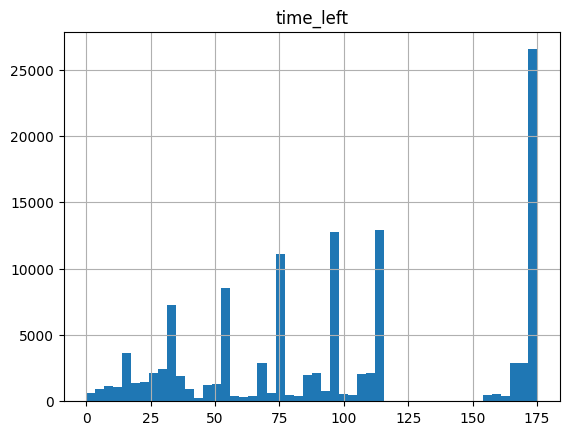

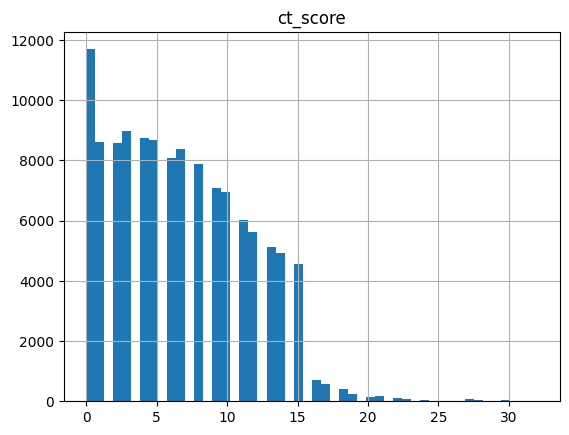

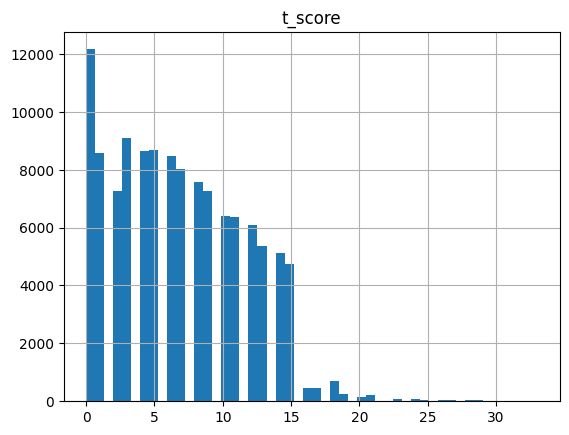

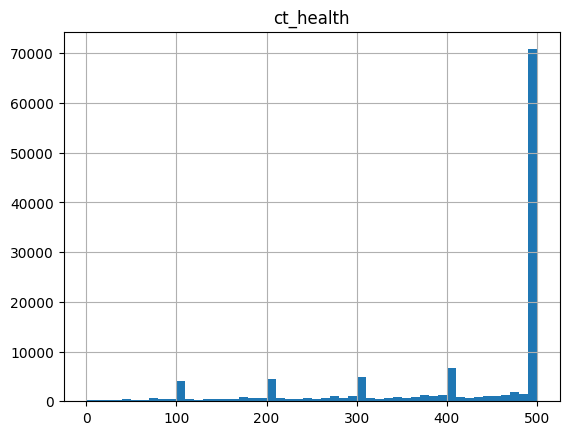

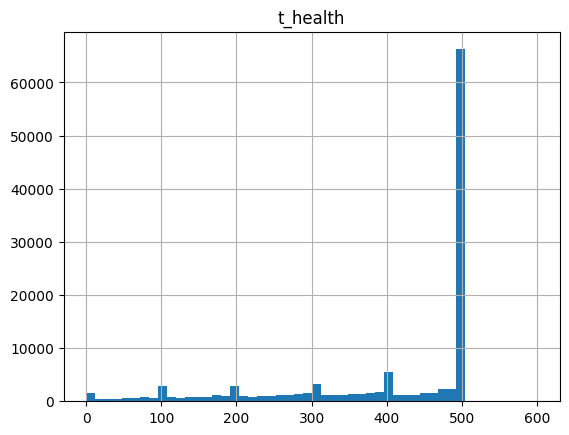

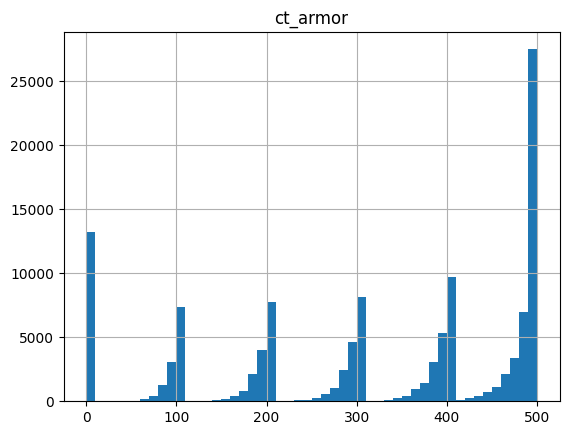

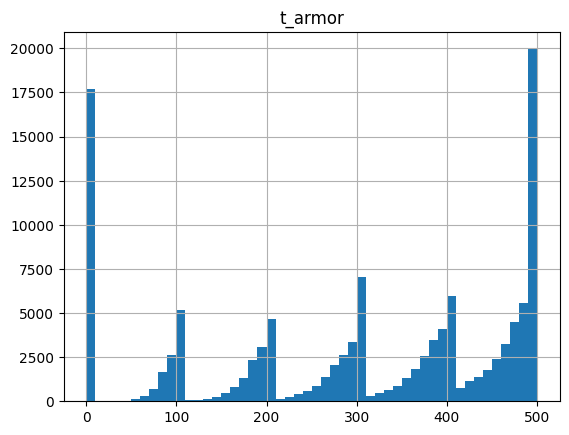

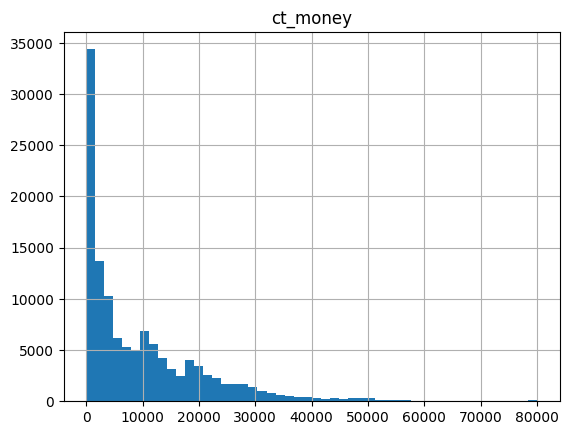

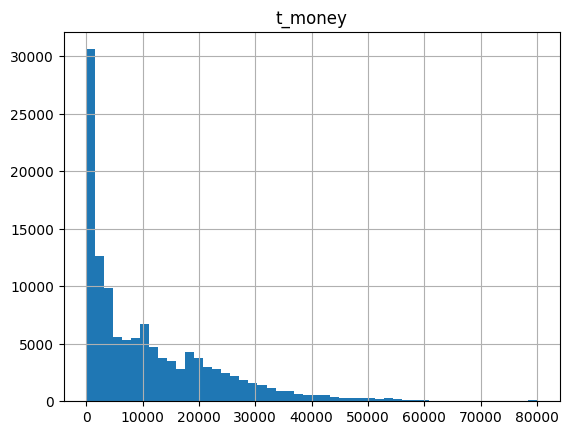

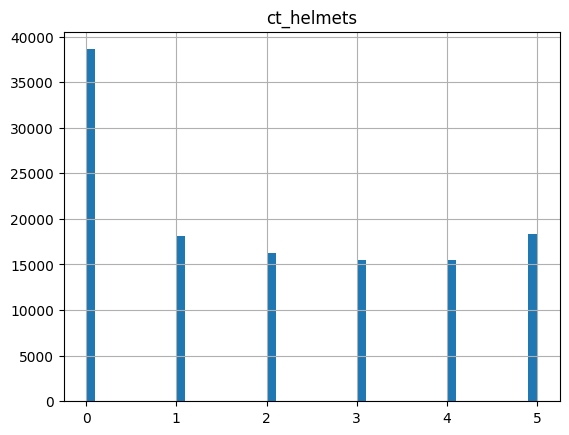

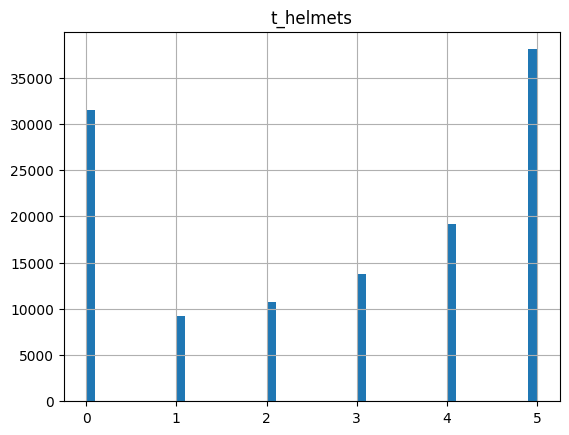

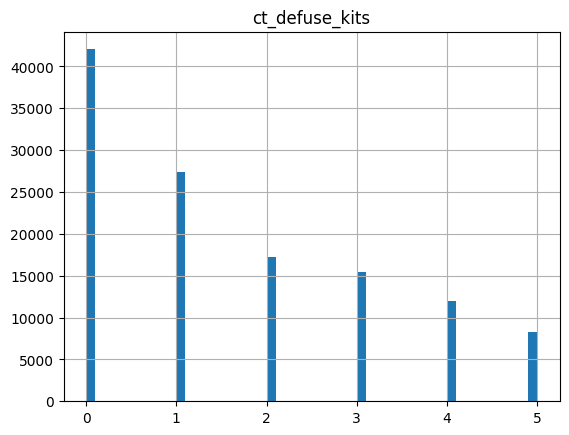

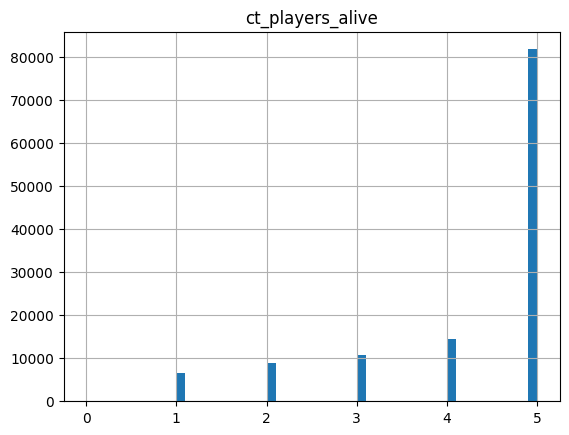

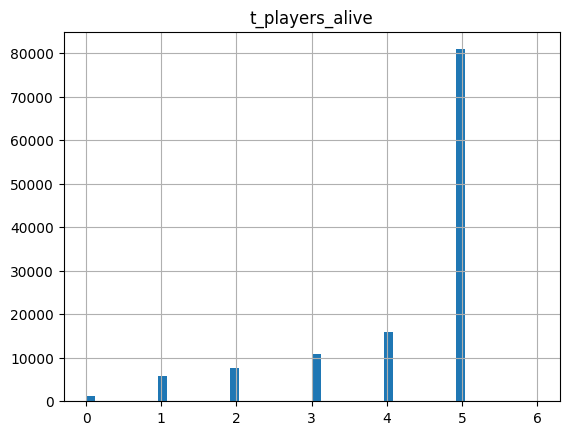

In [40]:
columns = data.columns.to_list()
columns.remove('map')
columns.remove('bomb_planted')

for column in columns:
    data.hist(column, bins = 50)

Разберем спорные столбцы:
1) 'time_left' - большое количество значений находится в районе 175, но так один раунд длится ровно 175 секунд и в начале каждого раунда собирается статистика, то неудивительно, что таких значений больше остальных.
2) 'ct_health' и 't_health' - в обоих столбцах большую часть занимает значение 500, это объясняется тем, что в начале раунда у каждого игрока 100 показателей здоровья, умножаем на 5(количество игроков в одной команде) и получаем значение 500.
3) 't_armor' и 'ct_armor' - ситуация как в предыдущем пункте, пока все игроки живы и у каждого есть броня, то значение на команду = 500.
4) 'ct_players_alive' и 't_players_alive' - следует из пункта 1, так как чаще всего статистика бралась в начале раунда, то все персонажи еще живы.
    Исходя из всего выесказанного можно сделать вывод, что распределение данных выглядит естественно и обработка выбросов не требуется.

## Разделение выборок
Отделим целевой признак от данных, разделим полученные датасеты на тренировочные и тестовые выборки

In [54]:
data = data.drop(['map'], axis=1)
data = data.drop(['bomb_planted'], axis=1)

y = data['t_score']
X = data.drop(['t_score'], axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [56]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((97928, 13), (97928,), (24482, 13), (24482,))

## Составим Регрессии


Линейная регрессия

<Axes: >

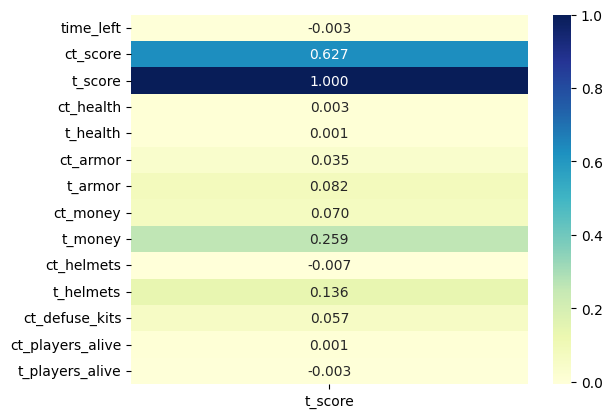

In [57]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix[['t_score']], annot=True, cmap="YlGnBu", fmt=".3f")

Наиболее подходящими являются столбцы 'ct_score' и 't_money'

In [62]:
train_lr = X_train['t_money'].values.reshape(-1,1)
test_lr = X_test['t_money'].values.reshape(-1,1)

lr = LinearRegression().fit(train_lr, y_train)
y_predict = lr.predict(test_lr)

In [63]:
# Вес предиктора
lr.coef_

array([0.00010526])

In [174]:
## Создадим функцию для вывода ошибок
def errors(y_test, y_predict):
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = sqrt(mean_squared_error(y_test, y_predict))
    MAPE = sqrt(mean_absolute_percentage_error(y_test, y_predict))
    R2 = r2_score(y_test, y_predict)

    return  {'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE, 'MAPE': MAPE, 'R2': R2} 

In [178]:
# Ошибки 
errors_lr = errors(y_test, y_predict)
print(errors_lr)

{'MAE': 2.9852857922176477, 'MSE': 13.169525856456806, 'RMSE': 3.6289841356028005, 'MAPE': 41599191.049171366, 'R2': 0.4249907406701092}


## Ridge

In [76]:
## Найдем параметр для регуляризации сеткой
r_parameters = {'alpha': np.arange(0.01, 1, 0.1)}

In [77]:
best_ridge = GridSearchCV(Ridge(), r_parameters).fit(train_lr, y_train)
best_ridge.best_params_

{'alpha': 0.91}

Оптимальный параметр - 0.91

Обучим данную модель учитывая Ridge

In [90]:
ridge_lr = Ridge(alpha=0.91).fit(X_train[['t_money']], y_train)
y_predict_ridge = ridge_lr.predict(X_test[['t_money']])

In [180]:
errors_ridge_lr = errors(y_test, y_predict_ridge)
print(errors_ridge_lr)

{'MAE': 2.9852846174545555, 'MSE': 13.16946555699552, 'RMSE': 3.6289758275573454, 'MAPE': 41599529.410032496, 'R2': 0.4249933734716961}


In [92]:
ridge_lr.coef_

array([0.00010526])

## Lasso

In [93]:
# Массив допустимых параметров
l_parameters = {'alpha': np.arange(0.01, 1, 0.1)}

Обучим данную модель учитывая Lasso

In [94]:
best_lasso = GridSearchCV(Lasso(), l_parameters).fit(train_lr, y_train)
best_lasso.best_params_

{'alpha': 0.91}

In [96]:
lasso_lr = Ridge(alpha=0.91).fit(X_train[['t_money']], y_train)
y_predict_lasso = lasso_lr.predict(X_test[['t_money']])

In [181]:
errors_lasso_lr = errors(y_test,  y_predict_lasso)
print(errors_lasso_lr)

{'MAE': 2.985337701383784, 'MSE': 13.12486250459061, 'RMSE': 3.622825210328344, 'MAPE': 41562009.71902521, 'R2': 0.4269408367598011}


In [98]:
lasso_lr.coef_

array([0.00010526])

## Elastic Net

In [101]:
elastic_lr = ElasticNet(alpha=10, l1_ratio=0.1).fit(X_train[['t_money']], y_train)
y_predict_elastic = elastic_lr.predict(X_test[['t_money']])

In [182]:
errors_elastic_lr = errors(y_test, y_predict_elastic)
print(errors_elastic_lr)

{'MAE': 3.060109803841336, 'MSE': 13.411161366067509, 'RMSE': 3.662125252645997, 'MAPE': 44729638.0398646, 'R2': 0.4144404249697965}


In [103]:
elastic_lr.coef_

array([0.00010525])

## Заключение


Сравнивая полученные результаты, делаем вывод что наилучшая модель обучения среди данных - это Elastic Net, хотя значения практически не отличаются друг от друга.

## Масштабирование


In [107]:
scaler = StandardScaler()

In [108]:
scaler.fit(X_train)

StandardScaler()

In [109]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Множественная линейнаяя регрессия

In [111]:
mlr = LinearRegression().fit(X_train, y_train)
y_pred = mlr.predict(X_test)


In [183]:
errors_mlr = errors(y_test, y_pred)
print(errors_mlr)

{'MAE': 2.9874190174063338, 'MSE': 13.496968246759188, 'RMSE': 3.6738220216498223, 'MAPE': 38910720.89734633, 'R2': 0.41069391568391056}


In [113]:
mlr.coef_

array([ 0.1244253 ,  3.15954496, -0.08299825,  0.03759606,  0.08496528,
        0.34803909, -0.8416908 ,  1.44101446, -0.40930167,  0.15503263,
        0.19059152,  0.28829818, -0.63865938])

Несколько значний близки к 0

## Ridge

In [114]:
r_parameters = {'alpha': np.arange(0, 1, 0.1)}

best_ridge = GridSearchCV(Ridge(), r_parameters).fit(X_train, y_train)
best_ridge.best_params_

{'alpha': 0.9}

In [117]:
ridge_mlr = Ridge(alpha=0.91).fit(X_train, y_train)
y_predict_ridge = ridge_mlr.predict(X_test)

In [118]:
ridge_mlr.coef_

array([ 0.1244196 ,  3.15951165, -0.08292414,  0.03753315,  0.08497997,
        0.34801194, -0.84165759,  1.44098575, -0.40930376,  0.15505314,
        0.19057859,  0.28822389, -0.63858966])

In [184]:
errors_ridge_mlr = errors(y_test, y_predict_ridge)
print(errors_ridge_mlr)

{'MAE': 2.9852846174545555, 'MSE': 13.16946555699552, 'RMSE': 3.6289758275573454, 'MAPE': 41599529.410032496, 'R2': 0.4249933734716961}


Наблюдаем изменение значений

## Lasso

In [122]:
best_lasso = GridSearchCV(Lasso(), l_parameters).fit(X_train, y_train)
best_lasso.best_params_

{'alpha': 0.01}

In [124]:
lasso_mlr = Lasso(alpha=0.01).fit(X_train, y_train)
y_predict_lasso = lasso_mlr.predict(X_test)

In [185]:
errors_lasso_mlr = errors(y_test, y_predict_lasso)
print(errors_lasso_mlr)

{'MAE': 2.985337701383784, 'MSE': 13.12486250459061, 'RMSE': 3.622825210328344, 'MAPE': 41562009.71902521, 'R2': 0.4269408367598011}


In [127]:
lasso_mlr.coef_

array([ 0.07232766,  3.15094074,  0.        , -0.        ,  0.06958765,
        0.33028861, -0.81328466,  1.42369193, -0.36255945,  0.13760877,
        0.14361498,  0.20923344, -0.55585605])

## ElasticNet

In [130]:
elastic_model = ElasticNet(max_iter=100000)
elastic_parametrs = {'alpha':[0.1,1,10,100],'l1_ratio':[0.1,0.75,0.99,1]}
best_elastic = GridSearchCV(elastic_model, param_grid=elastic_parametrs,scoring = 'neg_mean_squared_error')
best_elastic.fit(X_train, y_train)
best_elastic.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

In [131]:
elastic_mlr = ElasticNet(alpha=0.1, l1_ratio=0.1).fit(X_train, y_train)
y_predict_elastic = elastic_mlr.predict(X_test)

In [186]:
errors_elastic_mlr = errors(y_test, y_predict_elastic)
print(errors_elastic_mlr)

{'MAE': 3.060109803841336, 'MSE': 13.411161366067509, 'RMSE': 3.662125252645997, 'MAPE': 44729638.0398646, 'R2': 0.4144404249697965}


In [133]:
elastic_mlr.coef_

array([ 0.04427448,  2.86106951,  0.02067475, -0.08004611,  0.13247663,
        0.20809745, -0.58337696,  1.22486829, -0.34608477,  0.22758135,
        0.07737782,  0.09983828, -0.35299488])

Наиулчшей моделью оказалась модель Lasso, модель ElasticNet очень близка к ней по всем поазателям

## Полиномиальная регрессия

In [135]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', LinearRegression())] 

In [136]:
pipe = Pipeline(Input)
pipe

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [137]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [138]:
y_predict = pipe.predict(X_test)

In [187]:
errors_plr = errors(y_test, y_predict)
print(errors_plr)

{'MAE': 2.9852857922176477, 'MSE': 13.169525856456806, 'RMSE': 3.6289841356028005, 'MAPE': 41599191.049171366, 'R2': 0.4249907406701092}


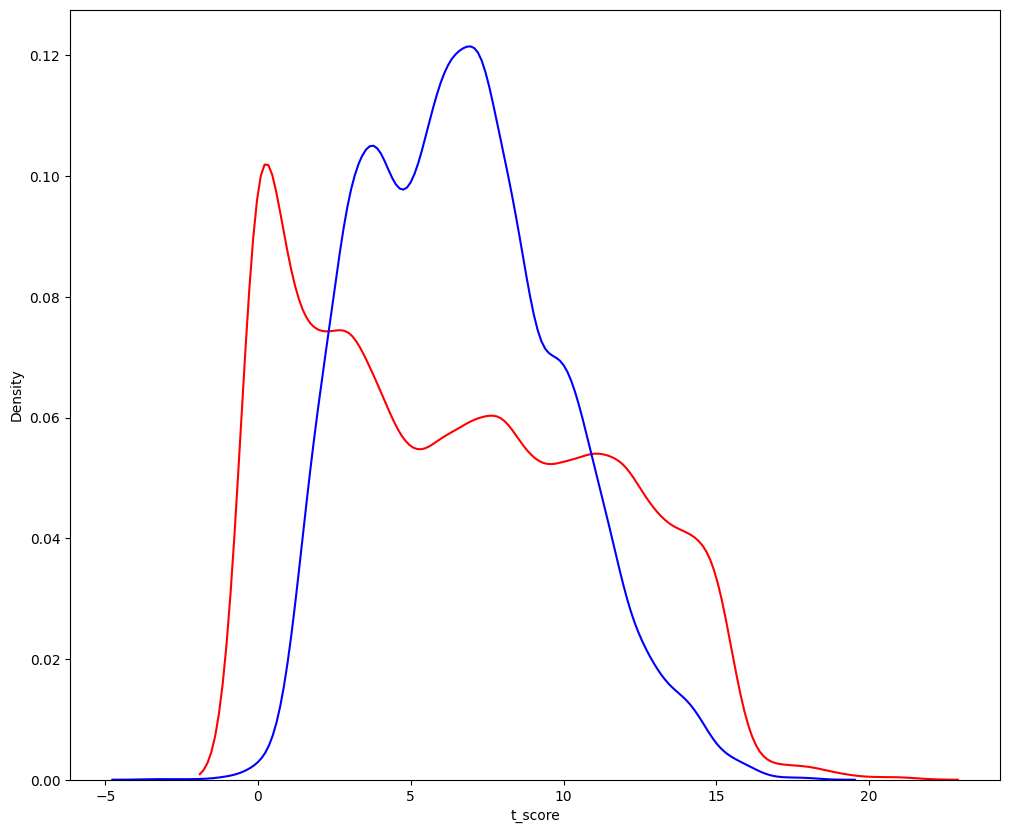

In [146]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict, hist=False, color='Blue', label='Predicted values')
plt.show()

Наблюдаем, что в целом модель неплохо предсказывает значения, однако отклонения все же имеются

## Ridge

In [147]:
Input = [('standardscaler', StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Ridge(alpha=0.9))]
pipe_ridge = Pipeline(Input)
pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', Ridge(alpha=0.9))])

In [148]:
y_predict_ridge = pipe_ridge.predict(X_test)
y_predict_ridge

array([2.43776159, 2.55232362, 1.89332582, ..., 9.72568769, 9.71361088,
       9.75647572])

In [188]:
errors_ridge_plr = errors(y_test, y_predict_ridge)
print(errors_ridge_plr)

{'MAE': 2.9852846174545555, 'MSE': 13.16946555699552, 'RMSE': 3.6289758275573454, 'MAPE': 41599529.410032496, 'R2': 0.4249933734716961}


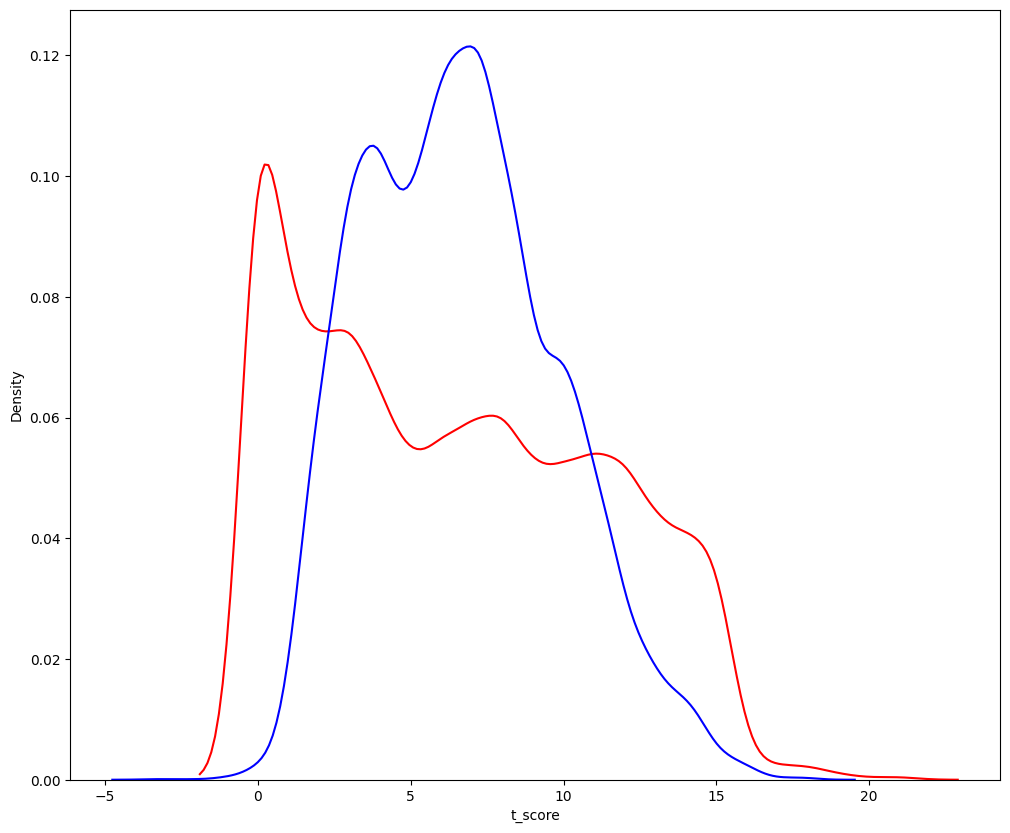

In [150]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict_ridge, hist=False, color='Blue', label='Predicted values')
plt.show()

Показатели практически не изменились

## Lasso

In [163]:
Input = [('standardscaler', StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', Lasso(alpha=0.01))]
pipe_lasso = Pipeline(Input)
pipe_lasso.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', Lasso(alpha=0.01))])

In [164]:
y_predict_lasso = pipe_lasso.predict(X_test)
y_predict_lasso

array([2.51344698, 2.52592595, 2.13327219, ..., 9.7096027 , 9.74264795,
       9.76915944])

In [189]:
errors_lasso_plr = errors(y_test, y_predict_lasso)
print(errors_lasso_plr)

{'MAE': 2.985337701383784, 'MSE': 13.12486250459061, 'RMSE': 3.622825210328344, 'MAPE': 41562009.71902521, 'R2': 0.4269408367598011}


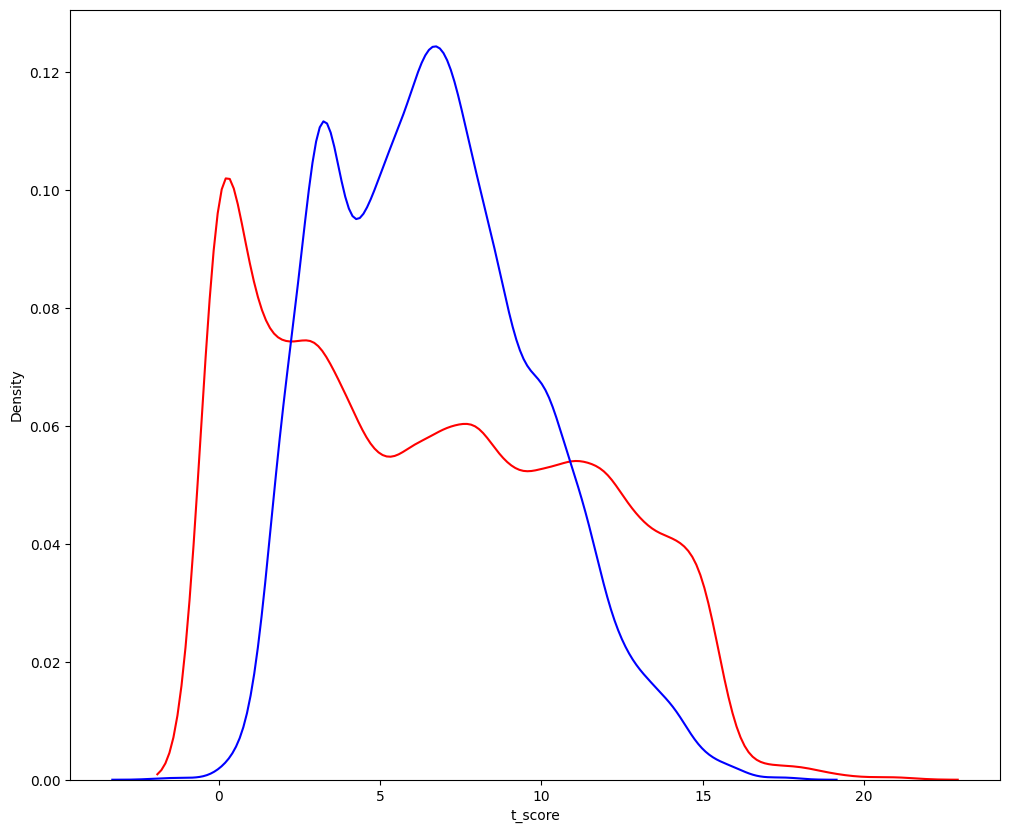

In [166]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict_lasso, hist=False, color='Blue', label='Predicted values')
plt.show()

Показатели также практически не изменились

## Elactic Net

In [167]:
Input = [('polynomial', PolynomialFeatures(degree=2, include_bias=False)), ('model', ElasticNet(alpha=0.1, l1_ratio=0.1))]
pipe_elastic = Pipeline(Input)
pipe_elastic.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', ElasticNet(alpha=0.1, l1_ratio=0.1))])

In [168]:
y_predict_elastic = pipe_elastic.predict(X_test)
y_predict_elastic

array([3.13283382, 3.11768719, 2.73139451, ..., 9.37724237, 9.38813467,
       9.38335397])

In [190]:
errors_elastic_plr = errors(y_test, y_predict_elastic)
print(errors_elastic_plr)

{'MAE': 3.060109803841336, 'MSE': 13.411161366067509, 'RMSE': 3.662125252645997, 'MAPE': 44729638.0398646, 'R2': 0.4144404249697965}


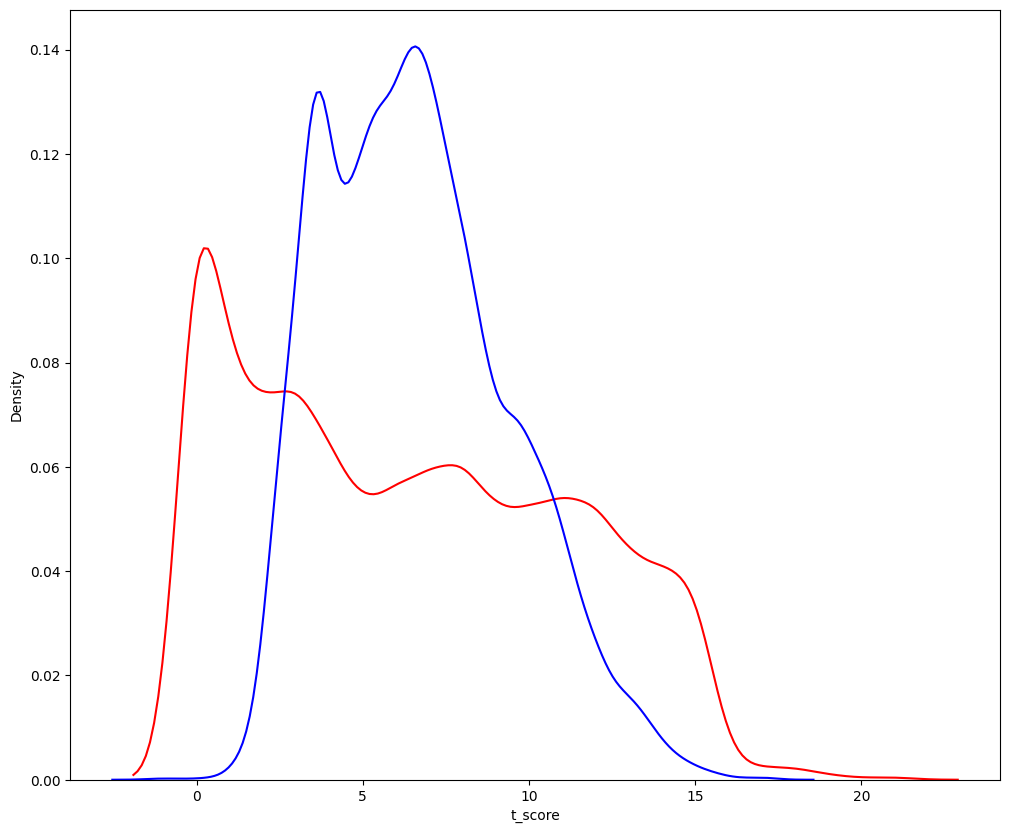

In [170]:
plt.figure(figsize=(12,10))
ax2 = sns.distplot(y_test, hist=False, color='Red', label='Actual values')
sns.distplot(y_predict_elastic, hist=False, color='Blue', label='Predicted values')
plt.show()

Видими небольшое изменение показателей

Наилучшей моделью можно считать Lasso

## Выбор лучшей модели

In [191]:
print(errors_elastic_lr)
print(errors_lasso_mlr)
print(errors_elastic_plr)

{'MAE': 3.060109803841336, 'MSE': 13.411161366067509, 'RMSE': 3.662125252645997, 'MAPE': 44729638.0398646, 'R2': 0.4144404249697965}
{'MAE': 2.985337701383784, 'MSE': 13.12486250459061, 'RMSE': 3.622825210328344, 'MAPE': 41562009.71902521, 'R2': 0.4269408367598011}
{'MAE': 3.060109803841336, 'MSE': 13.411161366067509, 'RMSE': 3.662125252645997, 'MAPE': 44729638.0398646, 'R2': 0.4144404249697965}


## Учитывая полученные результаты, можно сказать, что наилучшей моделью среди рассмотренных можно считать множественную линейную регрессию.